In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

In [ ]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict, Text
import pandas as pd
import datetime
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
#To ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To supress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#To display all the columns and rows
pd.set_option('display.max_columns', 1000); 
pd.set_option('display.max_rows', 1000); 
pd.set_option('display.width', 1000);

In [ ]:
#Reading all the three files
path = "/content/drive/MyDrive/Miscellaneous/ratings.csv"
ratings = pd.read_csv(path)
ratings.head(7)

,userId,movieId,rating,timestamp
0,1,296,5.000,1147880044
1,1,306,3.500,1147868817
2,1,307,5.000,1147868828
3,1,665,5.000,1147878820
4,1,899,3.500,1147868510
5,1,1088,4.000,1147868495
6,1,1175,3.500,1147868826


In [ ]:
path = "/content/drive/MyDrive/Miscellaneous/movies.csv"
movies = pd.read_csv(path)
movies.tail(8)

,movieId,title,genres
62415,209151,Mao Zedong 1949 (2019),(no genres listed)
62416,209153,Happy Flight (2008),Comedy|Drama
62417,209155,Santosh Subramaniam (2008),Action|Comedy|Romance
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)
62422,209171,Women of Devil's Island (1962),Action|Adventure|Drama


In [ ]:
path = "/content/drive/MyDrive/Miscellaneous/tags.csv"
tags = pd.read_csv(path)
tags.tail(6)

,userId,movieId,tag,timestamp
1093354,162521,66934,Nathan Fillion,1427311616
1093355,162521,66934,Neil Patrick Harris,1427311611
1093356,162521,103341,cornetto trilogy,1427311259
1093357,162534,189169,comedy,1527518175
1093358,162534,189169,disabled,1527518181
1093359,162534,189169,robbery,1527518193


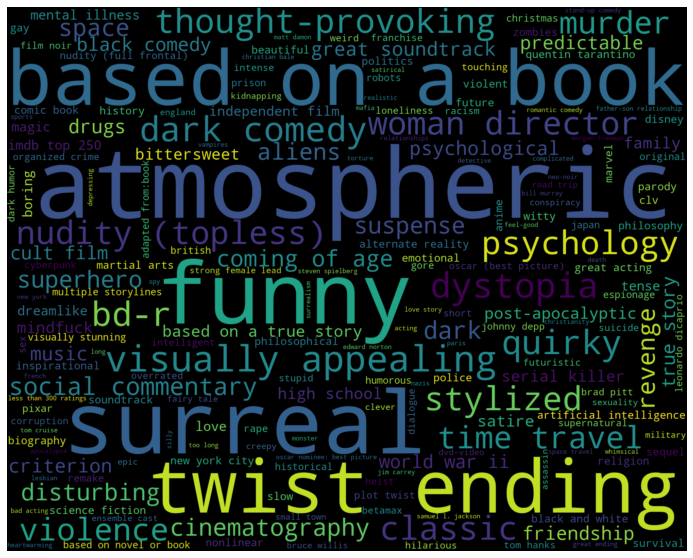

In [ ]:
#Generating a wordcloud using the movies and tags csv
from wordcloud import WordCloud
genres_unique = pd.DataFrame(movies['genres'].str.split('|').tolist()).stack().unique()
dftags = tags[pd.notnull(tags['tag'])]
data = dftags['tag'].apply(lambda x: x.lower())
#getting the frequency of diiferent tags
tag2freq = data.groupby(data).count()
for genre in genres_unique:
    genre = genre.lower()
    if genre in tag2freq:
        tag2freq.pop(genre)
#Plotting the graph
im = WordCloud(width=2000, height=1600).generate_from_frequencies(tag2freq)
plt.figure(figsize=(22,10))
plt.imshow(im, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Using only 10% of the dataset as of now
#Selecting 10% of the users randomly from the ratings df
rand_userIds = np.random.choice(ratings['userId'].unique(),size=int(len(ratings['userId'].unique())*0.1),replace=False)
#Picking data of only the randomly selected users from ratings df
ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]
print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 2509871 rows of data from 16254 users


In [ ]:
#Cleaning the datasets
from datetime import datetime
#Converting timestamp into date and displaying it 
ratings['date'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings.drop('timestamp', axis=1, inplace=True)
ratings.tail(8)

,userId,movieId,rating,date
24998411,162531,296,5.000,1996-04-08 19:55:42
24998412,162531,318,5.000,1996-04-08 19:55:42
24998413,162531,319,5.000,1996-04-08 19:55:42
24998414,162531,338,3.000,1996-04-08 19:55:42
24998415,162531,349,5.000,1996-04-08 19:55:42
24998416,162531,431,5.000,1996-04-08 19:55:42
24998417,162531,434,4.000,1996-04-08 19:55:42
24998418,162531,590,5.000,1996-04-08 19:55:42


In [ ]:
#Combining the ratings and movies so as to get movie names and genres
combtitle = pd.merge(ratings,movies,how='left',on='movieId')
combtitle.head()

,userId,movieId,rating,date,title,genres
0,11,277,2.500,2008-04-12 22:17:59,Miracle on 34th Street (1994),Drama
1,11,372,4.500,2008-04-12 22:18:16,Reality Bites (1994),Comedy|Drama|Romance
2,11,527,4.000,2008-04-12 22:27:43,Schindler's List (1993),Drama|War
3,11,593,4.500,2008-04-12 22:27:57,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,11,1203,2.500,2008-04-12 22:26:27,12 Angry Men (1957),Drama


In [ ]:
#Cleaning movie dataframe
movies.rename(columns={'id':'movieId'}, inplace=True)
#dropping genres column
movies.drop('genres', axis=1, inplace=True)
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
#Converting into string datatype
combtitle['userId'] = combtitle['userId'].astype(str)
combtitle.tail(8)

,userId,movieId,rating,date,title,genres
2509863,162531,296,5.000,1996-04-08 19:55:42,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2509864,162531,318,5.000,1996-04-08 19:55:42,"Shawshank Redemption, The (1994)",Crime|Drama
2509865,162531,319,5.000,1996-04-08 19:55:42,Shallow Grave (1994),Comedy|Drama|Thriller
2509866,162531,338,3.000,1996-04-08 19:55:42,Virtuosity (1995),Action|Sci-Fi|Thriller
2509867,162531,349,5.000,1996-04-08 19:55:42,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
2509868,162531,431,5.000,1996-04-08 19:55:42,Carlito's Way (1993),Crime|Drama
2509869,162531,434,4.000,1996-04-08 19:55:42,Cliffhanger (1993),Action|Adventure|Thriller
2509870,162531,590,5.000,1996-04-08 19:55:42,Dances with Wolves (1990),Adventure|Drama|Western


In [ ]:
movies = tf.data.Dataset.from_tensor_slices(dict(movies[['title']]))
ratings = tf.data.Dataset.from_tensor_slices(dict(combtitle[['userId', 'title', 'rating']]))

In [ ]:
#Converting into MapDataset
ratings = ratings.map(lambda x: {"title": x["title"],"userId": x["userId"],"rating": float(x["rating"])})
movies = movies.map(lambda x: x["title"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
print('Total Data: {}'.format(len(ratings)))
tf.random.set_seed(42)
shuffled = ratings.shuffle(1_000_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(650_000)
test = ratings.skip(650_000).take(180_188)

Total Data: 2509871


In [ ]:
movie_titles = movies.batch(10_000)
user_ids = ratings.batch(10_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 62325
Unique users: 16254


In [ ]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    super().__init__()
    embedding_dimension = 64

    # User and movie models which are returning the respective embeddings
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])
    # model to take in user and movie embeddings and predict ratings.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # Rating task is giving the error between actual ratings and predicted ratings
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )
    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [ ]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(10_000).cache()
cached_test = test.batch(10_000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
65/65 [==============================] - 4255s 65s/step - root_mean_squared_error: 1.3098 - factorized_top_k/top_1_categorical_accuracy: 6.8615e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0071 - factorized_top_k/top_10_categorical_accuracy: 0.0152 - factorized_top_k/top_50_categorical_accuracy: 0.0724 - factorized_top_k/top_100_categorical_accuracy: 0.1256 - loss: 88041.4658 - regularization_loss: 0.0000e+00 - total_loss: 88041.4658
Epoch 2/3
65/65 [==============================] - 4165s 64s/step - root_mean_squared_error: 0.9895 - factorized_top_k/top_1_categorical_accuracy: 8.9846e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0115 - factorized_top_k/top_10_categorical_accuracy: 0.0240 - factorized_top_k/top_50_categorical_accuracy: 0.1024 - factorized_top_k/top_100_categorical_accuracy: 0.1697 - loss: 84277.7559 - regularization_loss: 0.0000e+00 - total_loss: 84277.7559
Epoch 3/3
65/65 [==============================] - 4127s 64s/step - root_mean_squared_er

In [ ]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

19/19 [==============================] - 822s 42s/step - root_mean_squared_error: 1.0916 - factorized_top_k/top_1_categorical_accuracy: 1.6649e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0029 - factorized_top_k/top_50_categorical_accuracy: 0.0131 - factorized_top_k/top_100_categorical_accuracy: 0.0240 - loss: 83018.6596 - regularization_loss: 0.0000e+00 - total_loss: 83018.6596

Retrieval top-100 accuracy: 0.024
Ranking RMSE: 1.092


In [ ]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and  recommends movies out of the entire movies dataset.
    #Layers for retrieving top K recommendations from retrieval models.
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(1000), movies.batch(1000).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [ ]:
#Test with 29,35,40
predict_movie(125849, 1)

Top 1 recommendations for user 125849:

1. Murphy's Romance (1985)


In [ ]:
rand_userIds

array([121858, 125849,  75072, ..., 128862,  54558, 152543])